<a href="https://colab.research.google.com/github/guyez/CelebA-Conditional-GAN/blob/master/VAC%2BGAN%2Btfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors

- Simone Gayed Said
- Pierpasquale Colagrande


# Versatile Auxiliary Classifier with Generative Adversarial Network (VAC+GAN)

## Import of fundamental libraries

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Reshape, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_v3 import  InceptionV3
from tensorflow.keras.utils import plot_model
from scipy.linalg import sqrtm
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import cv2
from zipfile import ZipFile
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Input and parameter definition
Use the form on the right to insert the name of the folder on your Google Drive.

In [ ]:
BATCH_SIZE = 100                                         
ORIGINAL_IMAGE_SIZE = (218, 178, 3)                      
TARGET_IMAGE_SIZE = (64, 64, 3)                   
NUM_IMAGES = 202599                                      

# Folder on your Google Drive where all the checkpoints will be saved and where the dataset files are stored and loaded from
FOLDER_NAME = "Face Generation"                           # @param {type: "string"}
DATA_DRIVE_FOLDER = "drive/My Drive/" + FOLDER_NAME +"/"  # Full path to Drive folder

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-test/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()

feature_dict = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "labels": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
  }

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_image(example['image'])  
  normalized = (tf.cast(decoded, tf.float32)- 127.5)/ 127.5 
  image_tensor = tf.reshape(normalized, [ORIGINAL_IMAGE_SIZE[0], ORIGINAL_IMAGE_SIZE[1], ORIGINAL_IMAGE_SIZE[2]])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1])) # crop and reshape the image 
  labels = example['labels']
  labels = tf.cast(labels,tf.float32)
  return  {"image_input":image_tensor, "label_input": labels}


def load_dataset(filenames):
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)


dataset = load_dataset(filenames)

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):

  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTO)

  return ds

training_dataset = prepare_for_training(dataset)

In [ ]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(((image_batch[n]*127.5)+127.5)/255)
    plt.axis('off')
  plt.show()

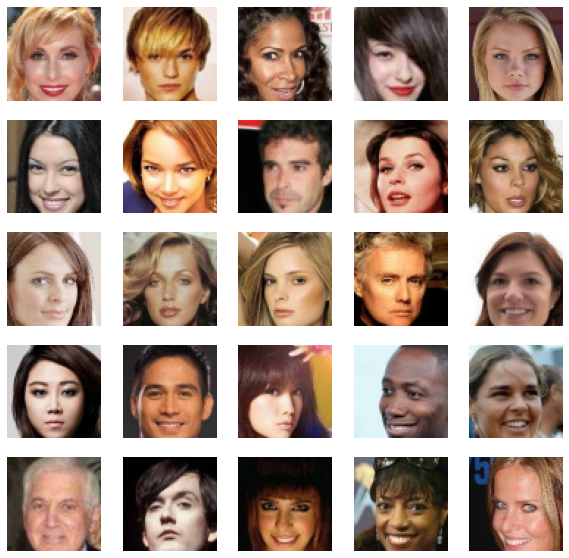

In [ ]:
image_batch = next(iter(training_dataset))
show_batch(image_batch["image_input"].numpy())

## Network model

In [ ]:
Z_LEN = 100         # Latent space size
N_ATTRIBUTES = 40   # Number of attributes per images

In [ ]:
discriminator_optimizer = Adam(lr=0.0002, beta_1=0)
classifier_optimizer = Adam(lr=0.0002, beta_1=0)
generator_optimizer = Adam(lr=0.00005, beta_1=0)

In [ ]:
class Conv2D(Conv2D):

  def __init__(self, filters, spectral_normalization=False, **kwargs):
    self.spectral_normalization = spectral_normalization
    super(Conv2D, self).__init__(filters, **kwargs)

  def build(self, input_shape):
    self.u = self.add_weight(name='u', shape=(1, self.filters), initializer='uniform', trainable=False)
    super(Conv2D, self).build(input_shape)

  def compute_spectral_normalization(self, training=True):
    if self.spectral_normalization:

      W_shape = self.kernel.shape.as_list()

      W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

      _u = self.u
      epsilon = 1e-4

      _v = K.dot(_u, W_mat) / (K.sum(K.dot(_u, W_mat) ** 2) ** 0.5 + epsilon)
      _u = K.dot(_v, K.transpose(W_mat)) / (K.sum(K.dot(_v, K.transpose(W_mat)) ** 2) ** 0.5 + epsilon)

      W_sn = K.sum(K.dot(_u, W_mat) * _v)

      if training:
        self.u.assign(_u)

      return self.kernel / W_sn
    else:
      return self.kernel

  def call(self, inputs, training=None):
    outputs = K.conv2d(inputs, self.compute_spectral_normalization(training=training),
                        strides=self.strides, padding=self.padding,
                        data_format=self.data_format,
                        dilation_rate=self.dilation_rate)

    if self.use_bias:
      outputs = K.bias_add(outputs, self.bias, data_format=self.data_format)

    if self.activation is not None:
      return self.activation(outputs)
    return outputs

  def compute_output_shape(self, input_shape):
    return super(Conv2D, self).compute_output_shape(input_shape)

In [ ]:
def define_generator():
  input_attributes = Input(shape=(Z_LEN + N_ATTRIBUTES, ))

  x = Dense(2048)(input_attributes)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.2)(x)

  x = Dense(256 * 8 * 8)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.2)(x)

  x = Reshape((8, 8, 256))(x)

  x = UpSampling2D()(x)
  x = Conv2D(filters=128, kernel_size=5, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = UpSampling2D()(x)
  x = Conv2D(filters=64, kernel_size=5, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = UpSampling2D()(x)
  x = Conv2D(filters=3, kernel_size=5, padding='same', spectral_normalization=True)(x)
  x = Activation('tanh')(x)

  model = Model(inputs=input_attributes, outputs=x, name="generator")

  return model

In [ ]:
generator = define_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              288768    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0 

In [ ]:
def define_discriminator(): 
  img_input = Input(shape=TARGET_IMAGE_SIZE)

  x = Conv2D(filters=32, kernel_size=5, strides=2,padding='same', spectral_normalization=True)(img_input)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=64, kernel_size=5, strides=2, padding='same', spectral_normalization=True)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=128, kernel_size=5, strides=2,padding='same', spectral_normalization=True)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=256, kernel_size=5, strides=2, padding='same', spectral_normalization=True)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = GlobalAveragePooling2D()(x)

  x = Dense(1)(x)

  model = Model(inputs=img_input, outputs=x,  name="discriminator")

  return model

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2464      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51328     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         205056    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)       

In [ ]:
def define_classifier():
  img_input = Input(shape=TARGET_IMAGE_SIZE)
  
  x = Conv2D(64, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(img_input)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(128, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(256, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(512, kernel_size=2, strides=2, padding='same', spectral_normalization=True)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = GlobalAveragePooling2D()(x)

  x = Dense(N_ATTRIBUTES, activation="sigmoid")(x)

  model = Model(inputs=img_input, outputs=x, name="classifier")

  return model

In [ ]:
classifier = define_classifier()
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0

In [ ]:
input_image = Input(shape=TARGET_IMAGE_SIZE)    
z = Input(shape=(Z_LEN + N_ATTRIBUTES, ))       
generated_image = generator(z)                  

logits_real = discriminator(input_image)        
logits_fake = discriminator(generated_image)    

class_real = classifier(input_image)           
class_fake = classifier(generated_image)        

loss_real = K.mean(K.relu(1-logits_real))     
loss_fake = K.mean(K.relu(1+logits_fake))
 
discriminator_loss = (loss_real + loss_fake) / 2

generator_loss = - K.mean(logits_fake)

In [ ]:
discriminator.trainable = True
classifier.trainable = True
generator.trainable = False

discriminator_train = Model(inputs=[input_image, z], outputs=[logits_real, logits_fake], name="discriminator_train") 
discriminator_train.add_loss(discriminator_loss)                                                                     
discriminator_train.compile(optimizer=discriminator_optimizer)                                                       
discriminator_train.summary()                                                                                        

classifier_train = Model(inputs=input_image, outputs=class_real, name="classifier_train")                                        
classifier_train.compile(loss="binary_crossentropy", optimizer=classifier_optimizer)                 
classifier_train.summary()                                                                                            

Model: "discriminator_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 64, 64, 3)    34955078    input_5[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1078817     input_4[0][0]                    
                                                                 generator[1][0]

In [ ]:
discriminator.trainable = False
classifier.trainable = False
generator.trainable = True

generator_train = Model(inputs=z, outputs=logits_fake, name="generator_train")                       
generator_train.add_loss(generator_loss)                                                                 
generator_train.compile(optimizer=generator_optimizer)                                                   
generator_train.summary()                                                                                 

generator_conditional_train = Model(inputs=z, outputs=class_fake, name="generator_conditional_train")     
generator_conditional_train.compile(loss = "binary_crossentropy", optimizer=generator_optimizer)     
generator_conditional_train.summary()                                                                    

Model: "generator_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
generator (Model)            (None, 64, 64, 3)         34955078  
_________________________________________________________________
discriminator (Model)        (None, 1)                 1078817   
_________________________________________________________________
tf_op_layer_Mean_2 (TensorFl [()]                      0         
_________________________________________________________________
tf_op_layer_Neg (TensorFlowO [()]                      0         
_________________________________________________________________
add_loss_1 (AddLoss)         ()                        0         
Total params: 36,033,895
Trainable params: 34,921,731
Non-trainable params: 1,112,164
_______________________________

## Training

In [ ]:
# @title Training

# Defines if the network will be trained
TRAIN = True                                           # @param {type:"boolean"}

# Defines if the weights will be saved
SAVE_WEIGHTS = False                                     # @param {type:"boolean"} 

NUM_TRAIN_DISC = 2                                      # Number of discriminator training iterations per epoch             
NUM_STEPS = NUM_IMAGES // (NUM_TRAIN_DISC * BATCH_SIZE) # Number of batches per epoch
NUM_EPOCHS = 25                                         # Number of epochs

In [ ]:
# Create noise and attribute samples for generation purposes
SAMPLE_NUM = 100
sample_noise = np.random.normal(size=(SAMPLE_NUM, Z_LEN))
sample_class = next(iter(training_dataset))["label_input"]
sample_combination = np.concatenate( (sample_noise, sample_class), axis=1)

In [ ]:
training_dataset = prepare_for_training(dataset)

In [ ]:
# If training is requested, do the training
if TRAIN:
  discriminator_losses_list = []
  generator_losses_list = []

  # Epoch loop
  for epoch in range(NUM_EPOCHS):
    print("Starting Epoch {}".format(epoch + 1))
      
    # Batches (steps) loop
    for step in tqdm(range(NUM_STEPS)):
          
      # Discriminator training iteration loop
      for discriminator_iteration in range(NUM_TRAIN_DISC):

        temp = next(iter(training_dataset))
        images = temp["image_input"].numpy()
        attributes = temp["label_input"].numpy()

        dumb = np.zeros_like(attributes)

        # Label smoothing
        attributes[attributes == 1] = 0.9

        noise = np.random.normal(size=(images.shape[0], Z_LEN))      
        z_combined = np.concatenate((noise, attributes), axis=1)     

        discriminator_loss = discriminator_train.train_on_batch([images, z_combined], dumb)

        discriminator_loss = classifier_train.train_on_batch(images, attributes)

        discriminator_losses_list.append(discriminator_loss)

      generator_loss = generator_train.train_on_batch(z_combined, dumb)
      generator_loss = generator_conditional_train.train_on_batch(z_combined, attributes)

      generator_losses_list.append(generator_loss)

    print("Discriminator loss: {}".format(np.mean(discriminator_losses_list[-NUM_TRAIN_DISC * NUM_STEPS:])))
    print("Generator loss: {}".format(np.mean(generator_losses_list[-NUM_STEPS:])))

    generator_sample = generator.predict(sample_combination)
    show_batch(generator_sample)

    # If requested, save weights to Google Drive
    if SAVE_WEIGHTS:
      print("Saving weights...")
      discriminator_train.save_weights(DATA_DRIVE_FOLDER + "weights/discriminator_train.h5")
      classifier_train.save_weights(DATA_DRIVE_FOLDER + "weights/classifier_train.h5")
      generator_train.save_weights(DATA_DRIVE_FOLDER + "weights/generator_train.h5")
      generator_conditional_train.save_weights(DATA_DRIVE_FOLDER + "weights/generator_conditional_train.h5")
      generator.save_weights(DATA_DRIVE_FOLDER + "weights/generator.h5")
      discriminator.save_weights(DATA_DRIVE_FOLDER + "weights/discriminator.h5")
      classifier.save_weights(DATA_DRIVE_FOLDER + "weights/classifier.h5")
      print()
      print("Weights saved.")

# If training is not requested, load weights from Google Drive
else:
  print("Loading weights...")
  discriminator_train.load_weights(DATA_DRIVE_FOLDER + "weights/discriminator_train.h5")
  classifier_train.load_weights(DATA_DRIVE_FOLDER + "weights/classifier_train.h5")
  generator_train.load_weights(DATA_DRIVE_FOLDER + "weights/generator_train.h5")
  generator_conditional_train.load_weights(DATA_DRIVE_FOLDER + "weights/generator_conditional_train.h5")
  generator.load_weights(DATA_DRIVE_FOLDER + "weights/generator.h5")
  discriminator.load_weights(DATA_DRIVE_FOLDER + "weights/discriminator.h5")
  classifier.load_weights(DATA_DRIVE_FOLDER + "weights/classifier.h5")
  print("Weights loaded.")

## Test

### Random attributes


In [ ]:
training_dataset = prepare_for_training(dataset)
sample_noise = np.random.normal(size=(SAMPLE_NUM, Z_LEN))
sample_class = next(iter(training_dataset))["label_input"]
sample_combination = np.concatenate( (sample_noise, sample_class), axis=1)

In [ ]:
generated_sample = generator.predict(sample_combination)
show_batch(generated_sample)

### Select specific attributes
Select the attributes to use for the generation of new faces from the forms below. By default, a set of attributes from the dataset is chosen.

In [ ]:
label = np.full(shape=(100,40), fill_value=0, dtype=np.int32)

In [ ]:
#@title Gender
Male = False #@param {type:"boolean"}
label[:,20] = int(Male)

In [ ]:
#@title Age
Young = True #@param {type:"boolean"}
label[:,39] = int(Young)

In [ ]:
#@title Face
Chubby = False #@param {type:"boolean"}
label[:,13] = int(Chubby)

Double_Chin = False #@param {type:"boolean"}
label[:,14] = int(Double_Chin)

High_Cheekbones = False #@param {type:"boolean"}
label[:,19] = int(High_Cheekbones)

Oval_Face = False #@param {type:"boolean"}
label[:,25] = int(Oval_Face)

Pale_Skin = False #@param {type:"boolean"}
label[:,26] = int(Pale_Skin)

Rosy_Cheeks = False #@param {type:"boolean"}
label[:,29] = int(Rosy_Cheeks)

Attractive = True #@param {type:"boolean"}
label[:,2] = int(Attractive)

In [ ]:
#@title Hair
Bald = False #@param {type:"boolean"}
label[:,4] = int(Bald)

Receding_Hairline = False #@param {type:"boolean"}
label[:,28] = int(Receding_Hairline)

Sideburns =  False #@param {type:"boolean"}
label[:,30] = int(Sideburns)

Bangs = False #@param {type:"boolean"}
label[:,5] = int(Bangs)

Black_Hair = True #@param {type:"boolean"}
label[:,8] = int(Black_Hair)

Blond_Hair = False #@param {type:"boolean"}
label[:,9] = int(Blond_Hair)

Brown_Hair = False #@param {type:"boolean"}
label[:,11] = int(Brown_Hair)

Gray_Hair = False #@param {type:"boolean"}
label[:,17] = int(Gray_Hair)

Straight_Hair = False #@param {type:"boolean"}
label[:,32] = int(Straight_Hair)

Wavy_Hair = False #@param {type:"boolean"}
label[:,33] = int(Wavy_Hair)


In [ ]:
#@title Eyes
Narrow_Eyes = False #@param {type:"boolean"}
label[:,23] = int(Narrow_Eyes)

Arched_Eyebrows = False #@param {type:"boolean"}
label[:,1] = int(Arched_Eyebrows)

Bushy_Eyebrows = False #@param {type:"boolean"}
label[:,12] = int(Bushy_Eyebrows)

Eyeglasses = False #@param {type:"boolean"}
label[:,15] = int(Eyeglasses)

Bags_Under_Eyes = False #@param {type:"boolean"}
label[:,3] = int(Bags_Under_Eyes)

In [ ]:
#@title Nose
Big_Nose = False #@param {type:"boolean"}
label[:,7] = int(Big_Nose)

Pointy_Nose = False #@param {type:"boolean"}
label[:,27] = int(Pointy_Nose)

In [ ]:
#@title Mouth
Big_Lips = False #@param {type:"boolean"}
label[:,6] = int(Big_Lips)

Mouth_Slightly_Open = False #@param {type:"boolean"}
label[:,21] = int(Mouth_Slightly_Open)

Smiling = True #@param {type:"boolean"}
label[:,31] = int(Smiling)

In [ ]:
#@title Facial Hair
Goatee = False #@param {type:"boolean"}
label[:,16] = int(Goatee)

Mustache = False #@param {type:"boolean"}
label[:,22] = int(Mustache)

No_Beard = True #@param {type:"boolean"}
label[:,24] = int(No_Beard)

In [ ]:
#@title Makeup
Heavy_Makeup = True #@param {type:"boolean"}
label[:,18] = int(Heavy_Makeup)

Wearing_Lipstick = False #@param {type:"boolean"}
label[:,36] = int(Wearing_Lipstick)

In [ ]:
#@title Accessories
Wearing_Earrings = False #@param {type:"boolean"}
label[:,34] = int(Wearing_Earrings)

Wearing_Hat = False #@param {type:"boolean"}
label[:,35] = int(Wearing_Hat)

Wearing_Necklace = False #@param {type:"boolean"}
label[:,37] = int(Wearing_Necklace)

Wearing_Necktie = False #@param {type:"boolean"}
label[:,38] = int(Wearing_Necktie)

In [ ]:
#@title Others
Five_o_Clock_Shadow = False #@param {type:"boolean"}
label[:,0] = int(Five_o_Clock_Shadow)

Blurry = False #@param {type:"boolean"}
label[:,10] = int(Blurry)

In [ ]:
sample_noise = np.random.normal(size=(SAMPLE_NUM, Z_LEN))
sample_combination = np.concatenate((sample_noise, attributes), axis=1)
generated_sample = generator.predict(sample_combination)
show_batch(generated_sample)

### FID Score

In [ ]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = cv2.resize(image, (new_shape, new_shape))
		images_list.append(new_image)
	return np.asarray(images_list)

def calculate_fid(act1 , act2):
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  ssdiff = np.sum((mu1 - mu2)**2.0)
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

inception_model = InceptionV3(include_top=False, pooling='avg')

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
def prepare_for_validation(ds, cache=True, shuffle_buffer_size=1000):

  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  # Take 10000 samples
  ds = ds.take(10000)

  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(buffer_size=AUTO)

  return ds


In [ ]:
validation_dataset = prepare_for_validation(dataset)
count = 0
pred_act = np.array([]).reshape((0, 2048))
img_act = np.array([]).reshape((0, 2048))
for batch in iter(validation_dataset):
  images = batch["image_input"].numpy()
  sample_class = batch["label_input"].numpy()
  batch_size = images.shape[0]
  print("Batch", count)
  print("Num samples", batch_size)
  sample_noise = np.random.normal(size=(BATCH_SIZE, Z_LEN))
  sample_comb = np.concatenate( (sample_noise, sample_class), axis=1)
  predictions = generator.predict(sample_comb)
  images1 = scale_images(images, 299)
  images2 = scale_images(predictions, 299)
  a = inception_model.predict(images1)
  b = inception_model.predict(images2)
  img_act = np.concatenate((img_act, a), axis = 0)
  pred_act = np.concatenate((pred_act, b), axis = 0)
  count += 1

In [ ]:
print("Calculating score for generation...")
fid_score = calculate_fid(img_act, pred_act)
print("Score for generation:")
print(np.round(fid_score, 3))

Calculating score for generation...
Score for generation:
27.415
